In [1]:
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

### the generation the fake dataset used for training the different models, and testing the algorithms, and optimizers

1. first we need to generate the x vector using `np.linspace` function
2. compute the y using the formula $y = 2*x + 25 + noise$. the noise is sampled from normal gassian distribution using the `randn` inside the package `np.random`, and then scale it to the x vector

In [2]:
n = 500000 # number of samples
x = np.linspace(10, 100, n)
print(f"the x vector of the shape: {x.shape}")
y = 2*x + 25 + np.random.randn(*x.shape) * (np.max(x) - np.min(x)) / 10
print(f"the y vector of the shape: {y.shape}")

the x vector of the shape: (500000,)
the y vector of the shape: (500000,)


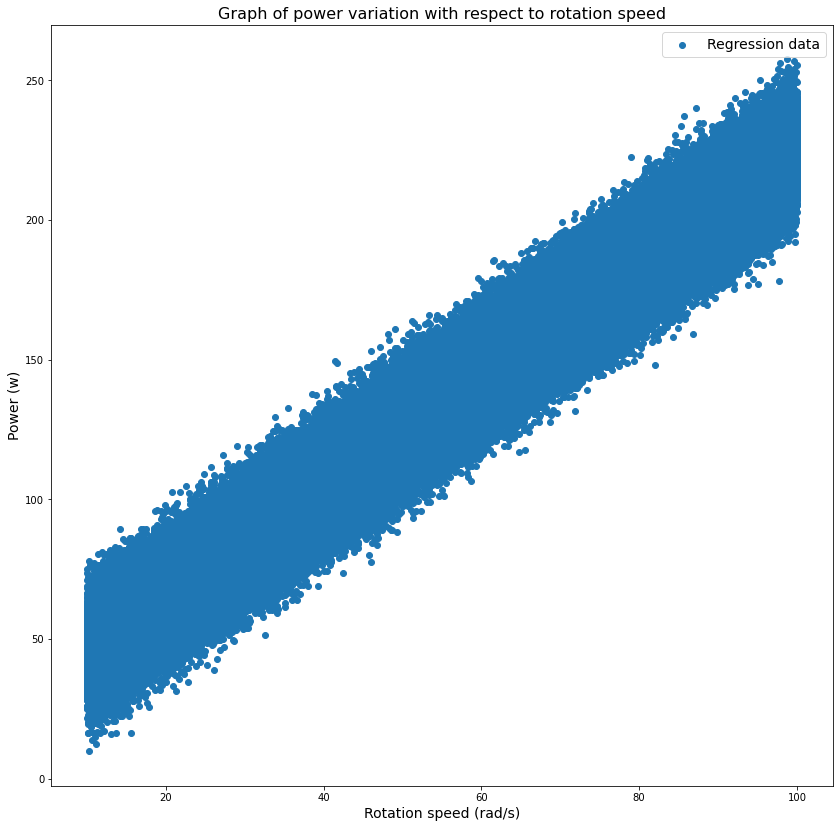

In [3]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x, y, label="Regression data")
ax.set_xlabel('Rotation speed (rad/s)', fontsize=14)
ax.set_ylabel('Power (w)', fontsize=14)
ax.set_title('Graph of power variation with respect to rotation speed', fontsize=16)
ax.legend(fontsize=14)

### Constructing the model to use to fit the dataset

the best model, and the simple model to fit the distribution, is linear model.
$$y = \theta_{0} + \theta_{1}\,x$$

## Fitting the model using analytic methods, by minimazing the mean square error

##### the mean error of the model is defined as follow
$$mse = \frac{1}{2\,m}\,\sum\limits_{i=1}^{m}(y_{i} - (\theta_{0} + \theta_{1}\,x_{i}) )^{2}$$
$$mse = \frac{1}{2\,m}\,E^{T}\,E $$
with `E` the column vector defined as follow:
$$E = \begin{bmatrix}y_{1}-(\theta_{0} + \theta_{1}\,x_{1}) &  y_{2}-(\theta_{0} + \theta_{1}\,x_{2})  & ... & y_{m}-(\theta_{0} + \theta_{1}\,x_{m})\end{bmatrix}^{T}$$

$$E = V - M\,\theta$$
with `V` defined as follow,
$$V = \begin{bmatrix}y_{1} & y_{2} & ...& y_{m}\end{bmatrix}^{T}$$

with `M` defined as follow,
$$M =  \begin{bmatrix} 1 & x_{1} \\ 1 & x_{2} \\ . & .\\ . & . \\ 1 & x_{m}\end{bmatrix}$$

Finding the best parameters $\theta_{0}$ and $\theta_{1}$, is equivalent to minimizing the `mse`, if we derive the term `mse` with respect to $\theta$, then we gonna find the following formula:
$$\theta = (M^{T}\,M)^{-1}\,M^{T}\,V$$

In [4]:
# Normalize the dataset
x_min, x_max = np.min(x), np.max(x)
y_min, y_max = np.min(y), np.max(y)
yn = (y-y_min)/(y_max-y_min)
xn = (x-x_min)/(x_max-x_min)

# Reorder the dataset
perm = np.random.permutation(n)
xn = xn[perm]
yn = yn[perm]

### Definition of the cost function, the gradient, and the hessian

In [5]:
def cost(theta, x, y):
    """computing the mean square error"""
    n = x.shape[0]
    delta = (theta @ np.vstack((np.ones(n), x))) - y
    return 0.5 * np.mean(delta**2)

def residuals(theta, x, y):
    """computing the residuals vector"""
    n = x.shape[0]
    return (theta @ np.vstack((np.ones(n), x))) - y

def dcost(theta, x, y):
    """the gradient of the cost function, with respect to theta"""
    n = x.shape[0]
    return np.mean((theta @ np.vstack((np.ones(n), x)) - y) * np.vstack((np.ones(n), x)), axis=1)

# NOTE:
# the  hessian matrix is a constant 2x2 matrix, so the optimization using newton minimization algorithm, 
# will be done in one step, and would be the exact solution as the one of analytic solutions
def ddcost(x):
    """the hessian matrix of the cost function"""
    return np.array([[1, np.mean(x)], [np.mean(x), np.mean(x**2)]])

In [6]:
M = np.asarray(np.stack((np.ones(n), xn), axis=1))
V = np.asarray(yn)
print(f"The first four rows of matrix M :\n{M[:4,:]}")
print(f"The first four rows the column vector V :\n{V[:4].reshape(-1, 1)}")

The first four rows of matrix M :
[[1.         0.10452821]
 [1.         0.87497175]
 [1.         0.23043046]
 [1.         0.72327145]]
The first four rows the column vector V :
[[0.168209  ]
 [0.76742887]
 [0.28795099]
 [0.66763635]]


# Method 1:

In [7]:
opt_theta1 = np.linalg.pinv(M.T @ M) @ M.T @ V
print(f"the theta: {opt_theta1}, achieving the loss of {cost(opt_theta1, xn, yn):.8f}")

the theta: [0.14193538 0.72724342], achieving the loss of 0.00065838


# Method 2:

In [8]:
opt_theta2, _, _, _ = np.linalg.lstsq(M, V, rcond=None)
print(f"the theta: {opt_theta2}, achieving the loss of {cost(opt_theta2, xn, yn):.8f}")

the theta: [0.14193538 0.72724342], achieving the loss of 0.00065838


# Method 3:

In [9]:
from scipy.linalg import lstsq as scipy_lstsq
opt_theta3, _, _, _ = scipy_lstsq(M, V, cond=None)
print(f"the theta: {opt_theta3}, achieving the loss of {cost(opt_theta3, xn, yn):.8f}")

the theta: [0.14193538 0.72724342], achieving the loss of 0.00065838


## Fitting the model using iterative methods

### Full-Batch Gradient Descent

In [10]:
def BGD(theta0, x, y, lr=0.001, lr_decay=0.99, min_lr=1e-4, tol=1e-8, max_iter=10000):
    """Full Batch Gradient Descent"""
    theta_vec, cost_vec = np.zeros((2, max_iter+1)), np.zeros(max_iter+1)
    theta_vec[:, 0], cost_vec[0] = theta0, cost(theta0, x, y)
    i = 0
    for i in range(max_iter):
        p_theta = -dcost(theta_vec[:,i], x, y)
        theta_vec[:, i+1] = theta_vec[:, i] + lr * p_theta
        cost_vec[i+1] = cost(theta_vec[:, i+1], x, y)
        lr = max(min_lr, lr*lr_decay)
        if np.abs(cost_vec[i+1] - cost_vec[i]) < tol:
            break
    return theta_vec[:,:i+2], cost_vec[:i+2]

In [11]:
theta0 = np.array([0, 0])
theta_vec, cost_vec = BGD(theta0, xn, yn, lr=1, lr_decay=0.99)
print(f"BGD Numerical solution: {theta_vec[:,-1]}, with loss: {cost_vec[-1]:.8f}")

BGD Numerical solution: [0.14341516 0.72447843], with loss: 0.00065870


### Mini-Batch Gradient Descent

In [12]:
def SGD(theta0, x, y, lr=0.01, lr_decay=0.99, min_lr=1e-4, tol=1e-8, max_epoch=100, batch_size=100):
    """Mini-Batch Gradient Descent"""
    n, i = x.shape[0], 0
    max_batch = int(np.ceil(n/batch_size))
    theta_vec, cost_vec = np.zeros((2, max_epoch*max_batch+1)), np.zeros((max_epoch+1))
    theta_vec[:, 0], cost_vec[0] = theta0, cost(theta0, x, y)
    for i in range(max_epoch):
        for j in range(max_batch):
            idx = i*max_batch+j
            batch_range = np.arange(batch_size*j, min(batch_size*(j+1),n))
            p_theta = -dcost(theta_vec[:, idx], x[batch_range], y[batch_range])
            theta_vec[:, idx+1] = theta_vec[:, idx] + lr * p_theta
            lr = max(min_lr, lr*lr_decay)
        cost_vec[i+1] = cost(theta_vec[:, (i+1)*max_batch], x, y)
        if np.abs(cost_vec[i+1] - cost_vec[i]) < tol:
            break

    return theta_vec[:,:(i+1)*max_batch+1], cost_vec[:i+2]

In [13]:
theta_vec, cost_vec = SGD(theta0, xn, yn, lr=1, lr_decay=0.99, batch_size=10000)
print(f"SGD Numerical solution: {theta_vec[:,-1]}, with loss: {cost_vec[-1]:.8f}")

SGD Numerical solution: [0.14236409 0.7264955 ], with loss: 0.00065840


###  Momentum SGD

In [14]:
def MomenSGD(theta0, x, y, lr=0.01, lr_decay=0.99, min_lr=1e-4, mu=0.96, tol=1e-8, max_epoch=100, batch_size=100):
    """Mini-batch gradient descent with momentum"""
    n, v, i = x.shape[0], 0, 0
    max_batch = int(np.ceil(n/batch_size))
    theta_vec, cost_vec = np.zeros((2, max_epoch*max_batch+1)), np.zeros(max_epoch+1)
    theta_vec[:, 0], cost_vec[0] = theta0, cost(theta0, x, y)
    for i in range(max_epoch):
        for j in range(max_batch):
            idx = i*max_batch+j
            batch_range = np.arange(batch_size*j, min(batch_size*(j+1),n))
            p_theta = -dcost(theta_vec[:, idx], x[batch_range], y[batch_range])
            v = mu * v + lr* p_theta
            theta_vec[:, idx+1] = theta_vec[:, idx] + v
            lr = max(min_lr, lr*lr_decay)
        cost_vec[i+1] = cost(theta_vec[:, (i+1)*max_batch], x, y)
        if np.abs(cost_vec[i+1] - cost_vec[i]) < tol:
            break
    return theta_vec[:,:(i+1)*max_batch+1], cost_vec[:i+2]

In [15]:
theta_vec, cost_vec = MomenSGD(theta0, xn, yn, lr=1, lr_decay=0.99, mu=0.9, batch_size=10000)
print(f"MomenSGD Numerical solution: {theta_vec[:,-1]}, with loss: {cost_vec[-1]:.8f}")

MomenSGD Numerical solution: [0.14191472 0.72726466], with loss: 0.00065838


### Nesterov Accelerated Gradient

In [16]:
def NagSGD(theta0, x, y, lr=0.01, lr_decay=0.99, min_lr=1e-4, mu=0.96, tol=1e-8, max_epoch=100, batch_size=100):
    """Mini-batch gradient descent with Nesterov modification"""
    n, v, i = x.shape[0], 0, 0
    max_batch= int(np.ceil(n/batch_size))
    theta_vec, cost_vec = np.zeros((2, max_epoch*max_batch+1)), np.zeros(max_epoch+1)
    theta_vec[:, 0], cost_vec[0] = theta0, cost(theta0, x, y)
    for i in range(max_epoch):
        for j in range(max_batch):
            idx = i*max_batch+j
            batch_range = np.arange(batch_size*j, min(batch_size*(j+1),n))
            p_theta = -dcost(theta_vec[:, idx] + mu * v, x[batch_range], y[batch_range])
            v = mu * v + lr*p_theta
            theta_vec[:, idx+1] = theta_vec[:, idx] + v
            lr = max(min_lr, lr*lr_decay)
        cost_vec[i+1] = cost(theta_vec[:, (i+1)*max_batch], x, y)
        if np.abs(cost_vec[i+1] - cost_vec[i]) < tol:
            break
    return theta_vec[:,:(i+1)*max_batch+1], cost_vec[:i+2]


In [17]:
theta_vec, cost_vec = NagSGD(theta0, xn, yn, lr=1, lr_decay=0.99, mu=0.9, batch_size=10000)
print(f"NagSGD Numerical solution: {theta_vec[:,-1]}, with loss: {cost_vec[-1]:.8f}")

NagSGD Numerical solution: [0.1419388  0.72733347], with loss: 0.00065838


### RMS Prop

In [18]:
def Adagrad(theta0, x, y, lr=0.01, lr_decay=0.99, min_lr=1e-4, mu=0.96, tol=1e-8, max_epoch=100, batch_size=100):
    """Mini-batch gradient descent with Nesterov modification"""
    n, i = x.shape[0], 0
    max_batch = int(np.ceil(n/batch_size))
    theta_vec, cost_vec = np.zeros((2, max_epoch*max_batch+1)), np.zeros(max_epoch+1)
    theta_vec[:, 0], cost_vec[0] = theta0, cost(theta0, x, y)
    s = np.zeros(2)
    for i in range(max_epoch):
        for j in range(max_batch):
            idx = i*max_batch+j
            batch_range = np.arange(batch_size*j, min(batch_size*(j+1),n))
            grad = dcost(theta_vec[:, idx], x[batch_range], y[batch_range])
            s += grad**2
            theta_vec[:, idx+1] = theta_vec[:, idx] - lr * grad / np.sqrt(s + 1e-8)
            lr = max(min_lr, lr*lr_decay)
        cost_vec[i+1] = cost(theta_vec[:, (i+1)*max_batch], x, y)
        if np.abs(cost_vec[i+1] - cost_vec[i]) < tol:
            break
    return theta_vec[:,:(i+1)*max_batch+1], cost_vec[:i+2]

In [19]:
theta_vec, cost_vec = Adagrad(theta0, xn, yn, lr=1, lr_decay=0.99, mu=0.9, batch_size=10000)
print(f"Adagrad Numerical solution: {theta_vec[:,-1]}, with loss: {cost_vec[-1]:.8f}")

Adagrad Numerical solution: [0.14204698 0.72707857], with loss: 0.00065838


### RMSProp

In [20]:
def RMSProp(theta0, x, y, lr=0.01, lr_decay=0.99, min_lr=1e-4, mu=0.96, tol=1e-8, max_epoch=100, batch_size=100):
    """Mini-batch gradient descent with Nesterov modification"""
    n, i = x.shape[0], 0
    max_batch = int(np.ceil(n/batch_size))
    theta_vec, cost_vec = np.zeros((2, max_epoch*max_batch+1)), np.zeros(max_epoch+1)
    theta_vec[:, 0], cost_vec[0] = theta0, cost(theta0, x, y)
    s = np.zeros(2)
    for i in range(max_epoch):
        for j in range(max_batch):
            idx = i*max_batch+j
            batch_range = np.arange(batch_size*j, min(batch_size*(j+1),n))
            grad = dcost(theta_vec[:, idx], x[batch_range], y[batch_range])
            s = mu * s + (1-mu) * grad**2
            theta_vec[:, idx+1] = theta_vec[:, idx] - lr * grad / np.sqrt(s + 1e-8)
            lr = max(min_lr, lr*lr_decay)
        cost_vec[i+1] = cost(theta_vec[:, (i+1)*max_batch], x, y)
        if np.abs(cost_vec[i+1] - cost_vec[i]) < tol:
            break
    return theta_vec[:,:(i+1)*max_batch+1], cost_vec[:i+2]

In [21]:
theta_vec, cost_vec = RMSProp(theta0, xn, yn, lr=1, lr_decay=0.99, mu=0.96, batch_size=10000)
print(f"RMSProp Numerical solution: {theta_vec[:,-1]}, with loss: {cost_vec[-1]:.8f}")

RMSProp Numerical solution: [0.14193615 0.72727712], with loss: 0.00065838


### Adam

In [22]:
def Adam(theta0, x, y, lr=0.01, lr_decay=0.99, min_lr=1e-4, b1=0.9, b2=0.999, dc=(1-1e-8), tol=1e-8, max_epoch=2500, batch_size=100):
    """Mini batch gradient descent with Adam modification"""
    n, b1t, i,  = x.shape[0], b1, 0
    max_batch= int(np.ceil(n/batch_size))
    theta_vec, cost_vec = np.zeros((2, max_epoch*max_batch+1)), np.zeros(max_epoch+1)
    theta_vec[:, 0], cost_vec[0] = theta0, cost(theta0, x, y)
    S, M = np.zeros((2,)), np.zeros((2,))
    for i in range(max_epoch):
        for j in range(max_batch):
            idx = i*max_batch+j
            batch_range = np.arange(batch_size*j, min(batch_size*(j+1),n))
            b1t *= dc
            grad = dcost(theta_vec[:, idx], x[batch_range], y[batch_range])
            M = b1t * M + (1 - b1t) * grad
            S = b2 * S + (1 - b2) * grad**2
            m = M/(1-b1**(i+1))
            s = S/(1-b2**(i+1))
            theta_vec[:, idx+1] = theta_vec[:, idx] - lr * m / (np.sqrt(s)+1e-8)
            lr = max(min_lr, lr*lr_decay)
        cost_vec[i+1] = cost(theta_vec[:, (i+1)*max_batch], x, y)
        if np.abs(cost_vec[i+1] - cost_vec[i]) < tol:
            break
    return theta_vec[:,:(i+1)*max_batch+1], cost_vec[:i+2]

In [23]:
theta_vec, cost_vec = Adam(theta0, xn, yn, lr=0.01, lr_decay=0.99, batch_size=10000)
print(f"Adam Numerical solution: {theta_vec[:,-1]}, with loss: {cost_vec[-1]:.8f}")

Adam Numerical solution: [0.14246545 0.72636715], with loss: 0.00065841


###  Backtracking Gradient Descent

In [24]:
def BackTrackLR(lr, rho, p_theta, theta, x, y):
    """ Back Tracking of the sufficient Learning Rate using the Armijo-condition"""
    lr, c = lr*2, 1e-4
    cost_theta, grad_theta = cost(theta, x, y), dcost(theta, x, y)
    while cost(theta + lr*p_theta, x, y) > (cost_theta + c*lr*grad_theta.T @ p_theta):
        lr *=rho
    return lr


def BackTrackSGD(theta0, x, y, rho=0.5, tol=1e-8, max_epoch=100, batch_size=100):
    """Mini-batch gradient descent, with backtracking of the learning rate"""
    n, i, lr = x.shape[0], 0, 2
    max_batch = int(np.ceil(n/batch_size))
    theta_vec, cost_vec = np.zeros((2, max_epoch*max_batch+1)), np.zeros((max_epoch+1))
    theta_vec[:, 0], cost_vec[0] = theta0, cost(theta0, x, y)
    for i in range(max_epoch):
        for j in range(max_batch):
            idx = i*max_batch+j
            batch_range = np.arange(batch_size*j, min(batch_size*(j+1),n))
            p_theta = -dcost(theta_vec[:, idx], x[batch_range], y[batch_range]) 
            lr = BackTrackLR(lr, rho, p_theta, theta_vec[:, i], x[batch_range], y[batch_range])
            theta_vec[:, idx+1] = theta_vec[:, idx] + lr * p_theta
        cost_vec[i+1] = cost(theta_vec[:, (i+1)*max_batch], x, y)
        if np.abs(cost_vec[i+1] - cost_vec[i]) < tol:
            break

    return theta_vec[:,:(i+1)*max_batch+1], cost_vec[:i+2]

In [25]:
theta_vec, cost_vec = BackTrackSGD(theta0, xn, yn, batch_size=10000)
print(f"Back Tracking SGD Numerical solution: {theta_vec[:,-1]}, with loss: {cost_vec[-1]:.8f}")

Back Tracking SGD Numerical solution: [0.357301   0.31187393], with loss: 0.00787673


## Second Order Methods

### Netwon method: super-linear convergence

In [26]:
def Newton(theta0, x, y, tol=1e-8, max_epoch=100, batch_size=100):
    """Mini-Batch Netwon Method"""
    n, i = x.shape[0], 0
    max_batch= int(np.ceil(n/batch_size))
    theta_vec, cost_vec = np.zeros((2, max_epoch*max_batch+1)), np.zeros(max_epoch+1)
    theta_vec[:, 0], cost_vec[0] = theta0, cost(theta0, x, y)
    for i in range(max_epoch):
        for j in range(max_batch):
            idx = i*max_batch+j
            batch_range = np.arange(batch_size*j, min(batch_size*(j+1),n))
            grad = dcost(theta_vec[:, idx], x[batch_range], y[batch_range])
            hess = ddcost(x[batch_range])
            theta_vec[:, idx+1] = theta_vec[:, idx] - np.linalg.inv(hess) @ grad
        cost_vec[i+1] = cost(theta_vec[:, (i+1)*max_batch], x, y)
        if np.abs(cost_vec[i+1] - cost_vec[i]) < tol:
            break
    return theta_vec[:,:(i+1)*max_batch+1], cost_vec[:i+2]

In [27]:
theta_vec, cost_vec = Newton(theta0, xn, yn, batch_size=10000)
print(f"Newton Numerical solution: {theta_vec[:,-1]}, with loss: {cost_vec[-1]:.8f}")

Newton Numerical solution: [0.14230485 0.72664939], with loss: 0.00065840


### BFGS method: high-linear convergence

In [28]:
from scipy.optimize import fmin_bfgs
bfgs_result = fmin_bfgs(f=cost, x0=theta0, fprime=dcost, args=(xn, yn), disp=False)
print(f"bfgs solution: {bfgs_result}")

bfgs solution: [0.14193117 0.72725104]


### L-BFGS method: high-linear convergence

In [29]:
from scipy.optimize import fmin_l_bfgs_b
lbfgs_result = fmin_l_bfgs_b(func=cost, x0=theta0, fprime=dcost, args=(xn, yn), disp=False)
print(f"l-bfgs solution: {lbfgs_result[0]}")

l-bfgs solution: [0.14193538 0.72724342]


### Conjugate gradient method: high-linear convergence

In [30]:
from scipy.optimize import fmin_cg
cg_result = fmin_cg(f=cost, x0=theta0, fprime=dcost, args=(xn, yn), disp=False)
print(f"cg solution: {cg_result}")

cg solution: [0.14193538 0.72724342]


### Newton conjugate gradient method: high-linear convergence

In [31]:
from scipy.optimize import fmin_ncg
ncg_result = fmin_ncg(f=cost, x0=theta0, fprime=dcost, args=(xn, yn), disp=False)
print(f"ncg solution: {ncg_result}")

ncg solution: [0.14193529 0.7272436 ]


###  Levenberg-Marquardt method: high-linear convergence

In [32]:
from scipy.optimize import least_squares
ml_result = least_squares(residuals, theta0, args=(xn, yn), method="lm")
if ml_result.success:
    print(f"Levenberg-Marquardt solution: {ml_result.x}")

Levenberg-Marquardt solution: [0.14193538 0.72724342]


# benchmark

In [33]:
lstsq_bench = %timeit -o opt_theta1 = np.linalg.pinv(M.T @ M) @ M.T @ V
fbgd_bench = %timeit -o theta_vec, cost_vec = BGD(theta0, xn, yn, lr=1, lr_decay=0.99)
mbgd_bench = %timeit -o theta_vec, cost_vec = SGD(theta0, xn, yn, lr=1, lr_decay=0.99, batch_size=10000)
mgd_bench = %timeit -o theta_vec, cost_vec = MomenSGD(theta0, xn, yn, lr=1, lr_decay=0.99, mu=0.9, batch_size=10000)
nag_bench = %timeit -o theta_vec, cost_vec = NagSGD(theta0, xn, yn, lr=1, lr_decay=0.99, mu=0.9, batch_size=10000)
adagrad_bench = %timeit -o theta_vec, cost_vec = Adagrad(theta0, xn, yn, lr=1, lr_decay=0.99, batch_size=10000)
rmsprop_bench = %timeit -o theta_vec, cost_vec = RMSProp(theta0, xn, yn, lr=1, lr_decay=0.99, batch_size=10000)
adam_bench = %timeit -o theta_vec, cost_vec = Adam(theta0, xn, yn, lr=1, lr_decay=0.99, batch_size=10000)
newton_bench = %timeit -o theta_vec, cost_vec = Newton(theta0, xn, yn, batch_size=10000)
bfgs_bench = %timeit -o bfgs_result = fmin_bfgs(f=cost, x0=theta0, fprime=dcost, args=(xn, yn), disp=False)
lbfgs_bench = %timeit -o lbfgs_result = fmin_l_bfgs_b(func=cost, x0=theta0, fprime=dcost, args=(xn, yn), disp=False)
cg_bench = %timeit -o cg_result = fmin_cg(f=cost, x0=theta0, fprime=dcost, args=(xn, yn), disp=False)
ncg_bench = %timeit -o ncg_result = fmin_ncg(f=cost, x0=theta0, fprime=dcost, args=(xn, yn), disp=False)
ml_bench = %timeit -o ml_result = least_squares(residuals, theta0, args=(xn, yn), method="lm")

5.14 ms ± 271 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
839 ms ± 6.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
51.2 ms ± 706 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
58.9 ms ± 952 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
45 ms ± 720 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
31.1 ms ± 714 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
112 ms ± 2.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
46.9 ms ± 440 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
21.5 ms ± 370 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
52.7 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
34.3 ms ± 814 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
34.5 ms ± 757 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
41.2 ms ± 702 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
46.3 ms ± 864 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
print(f"Analytic method:\t\t\t\t\t{lstsq_bench.average*1000:6.2f}ms")
print(f"Newton method:\t\t\t\t\t\t{newton_bench.average*1000:6.2f}ms")
print(f"L-BFGS method:\t\t\t\t\t\t{lbfgs_bench.average*1000:6.2f}ms")
print(f"Conjugate gradient method:\t\t\t\t{cg_bench.average*1000:6.2f}ms")
print(f"Newton conjugate method:\t\t\t\t{ncg_bench.average*1000:6.2f}ms")
print(f"Levenberg-marquardt method:\t\t\t\t{ml_bench.average*1000:6.2f}ms")
print(f"Nag method:\t\t\t\t\t\t{nag_bench.average*1000:6.2f}ms")
print(f"Gradient descente with momentum method:\t\t\t{mgd_bench.average*1000:6.2f}ms")
print(f"Gradient descente:\t\t\t\t\t{mbgd_bench.average*1000:6.2f}ms")
print(f"Adam method:\t\t\t\t\t\t{adam_bench.average*1000:6.2f}ms")
print(f"RMSProp method:\t\t\t\t\t\t{rmsprop_bench.average*1000:6.2f}ms")
print(f"Adagrad method:\t\t\t\t\t\t{adagrad_bench.average*1000:6.2f}ms")

Analytic method:					  5.14ms
Newton method:						 21.46ms
L-BFGS method:						 34.32ms
Conjugate gradient method:				 34.51ms
Newton conjugate method:				 41.21ms
Levenberg-marquardt method:				 46.34ms
Nag method:						 45.03ms
Gradient descente with momentum method:			 58.89ms
Gradient descente:					 51.20ms
Adam method:						 46.87ms
RMSProp method:						112.03ms
Adagrad method:						 31.12ms
